In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from scipy.signal import convolve
import scipy
from joblib import Parallel, delayed
import time
from scipy import sparse
import json
from tqdm import tqdm, tqdm_notebook

%run ../Scripts/coverage.py
%run ../Scripts/fitness.py
%run ../Scripts/immunity.py
%run ../Scripts/initMethods.py
%run ../Scripts/supMethods.py
%run ../Scripts/mutation.py

In [3]:
params = { #parameters relevant for the equations
    "Nh":         1000000,
    "N0":          100000,
    "R0":              20,
    "M":                1, #Also L, total number of spacers
    "mu":            0.01, #mutation rate
    "gamma_shape":     20, 
    "Np":               0, #Number of Cas Protein
    "dc":               3, #Required number of complexes to activate defence
    "h":              100, #coordination coeff
    "r":             2000, #cross-reactivity kernel
    "rate_HGT":         0,
    "beta":             0,
}
sim_params = { #parameters relevant for the simulation (including Inital Valuess)
    "xdomain":                   1000,
    "dx":                           1,
    "tf":                        1000,
    "dt":                           1,
    "initial_mean_n":           [0,0],
    "initial_mean_nh":          [0,0],
    "conv_size":                 4000,
    "num_threads":                 32,
    "tail_axis":               [1, 1],
    "hard_N0":                    False,
}

In [3]:
params, sim_params = init_cond(params, sim_params)

In [4]:
n = init_guassian(params["N"], sim_params, "n")
nh = init_exptail(params["Nh"], params, sim_params, "nh")
kernel_quarter = init_quarter_kernel(params, sim_params)

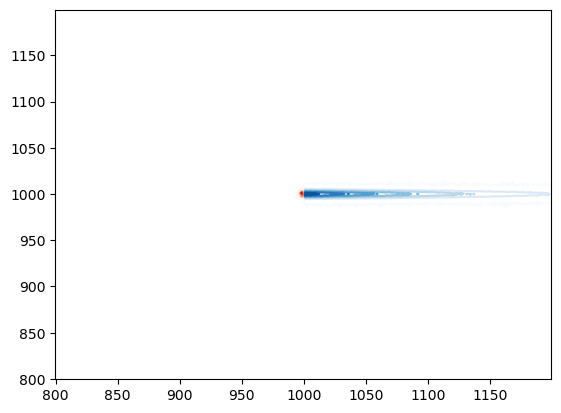

In [5]:
plt.figure()
plt.contour(n.todense(), cmap = "Reds")
plt.contour(nh.todense(), cmap = "Blues")
plt.margins(-0.4, -0.4)
plt.show()

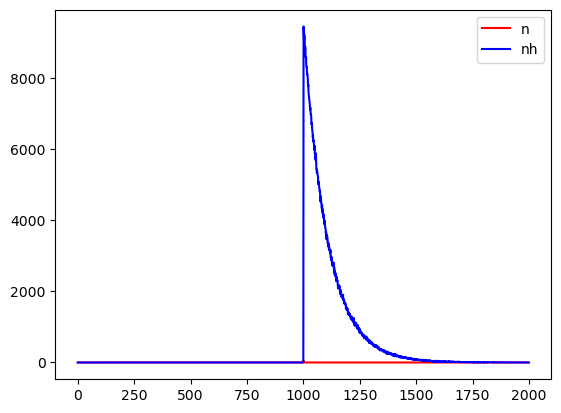

In [6]:
plt.figure()
# plt.plot(n.toarray().squeeze()[1000, 900:1100], color = "red", label = "n")
plt.plot(np.sum(n.toarray().squeeze(), axis = 0), color = "red", label = "n")
# plt.plot(nh.toarray().squeeze()[1000, 900:1100], color = "blue", label = "nh")
plt.plot(np.sum(nh.toarray().squeeze(), axis = 0), color = "blue", label = "nh")
# plt.xlim([25, 50])
plt.legend()

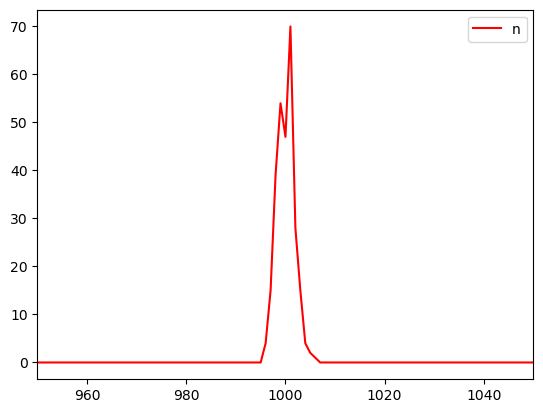

In [7]:
plt.figure()
# plt.plot(n.toarray().squeeze()[900:1100, 1000], color = "red", label = "n")
plt.plot(np.sum(n.toarray().squeeze(), axis = 1), color = "red", label = "n")
# plt.plot(nh.toarray().squeeze()[900:1100, 1000], color = "blue", label = "nh")
# plt.plot(np.sum(nh.toarray().squeeze(), axis = 1), color = "blue", label = "nh")
plt.xlim([950, 1050])
plt.legend()

In [8]:
sigma = sim_params["initial_var_n"]
v0 = params["v0"]
uc = params["uc"]
print(f"sigma: {sigma}")
print(f"v0: {v0}")
print(f"uc: {uc}")

sigma: 1.758362390812788
v0: 0.029372463825536214
uc: 2.1622597272742676


In [28]:
D = params["D"]
r = params["r"]
M = params["M"]
R0 = params["R0"]
N0 = params["N0"]

A = np.power((D*r)/(M*(np.power(R0, 1/M)-1)), 1/3)
B = M*(np.power(R0, 1/M)-1)/r
B = N0*np.power(D, 1/3)*np.power(B, 2/3)
B = np.power(24*np.log(B), 1/6)
print(f"sigma check: {A*B}")

A = np.power(D, 2/3)
A = A*np.power((M*(np.power(R0, 1/M)-1))/r,1/3)
B = M*(np.power(R0, 1/M)-1)/r
B = N0*np.power(D, 1/3)*np.power(B, 2/3)
B = np.power(24*np.log(B), 1/3)
print(f"v0 check: {A*B}")

A = np.power(D, 2/3)
A = (1/4)*np.power((D*r)/(M*(np.power(R0, 1/M)-1)),1/3)
B = M*(np.power(R0, 1/M)-1)/r
B = N0*np.power(D, 1/3)*np.power(B, 2/3)
B = np.power(24*np.log(B), 2/3)
print(f"uc check: {A*B}")

sigma check: 5.106516048506096
v0 check: 0.4954536169193563
uc check: 15.380594393387975


In [4]:
p_coverage = 0.2
M = 20
R0 = 20
Np = 100
dc = 3

def p_infection(p_coverage, M, Np, dc):
    p_infection = (1-p_coverage)**M

    for n in range(1, M+1):
        p_n_spacer = binomial_pdf(M, n, p_coverage)
        for d in range(0, dc+1):
            p_infection += binomial_pdf(Np, d, n/M)*p_n_spacer
    return p_infection

def p_1_infection(p_coverage, M, Np, dc):
    p_infection = (1-p_coverage)**M

    p_1_spacer = binomial_pdf(M, 1, p_coverage)
    for d in range(0, dc+1):
        p_infection += binomial_pdf(Np, d, 1/M)*p_1_spacer
    return p_infection


Text(0.5, 1.0, 'Probability of Infection at Np = 100, dc = 10')

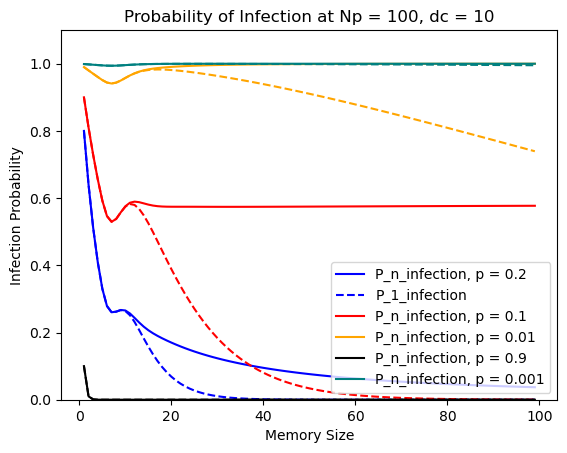

In [51]:
# M_range = np.power(10, np.arange(0, 3, 0.5))
M_range = np.arange(1, 100, 1)
p_coverage = 0.2
p_infection_range = []
p_1_infection_range = []
Np = 100
dc = 10

for M in M_range:
    M = int(M)
    p_infection_range.append(p_infection(p_coverage, M, Np, dc))
plt.plot(M_range, p_infection_range, label = "P_n_infection, p = 0.2", color = "blue")

for M in M_range:
    M = int(M)
    p_1_infection_range.append(p_1_infection(p_coverage, M, Np, dc))
plt.plot(M_range, p_1_infection_range, label = "P_1_infection", color = "blue", linestyle = "--")

p_coverage = 0.1
p_infection_range = []
p_1_infection_range = []
for M in M_range:
    M = int(M)
    p_infection_range.append(p_infection(p_coverage, M, Np, dc))
plt.plot(M_range, p_infection_range, label = "P_n_infection, p = 0.1", color = "red")

for M in M_range:
    M = int(M)
    p_1_infection_range.append(p_1_infection(p_coverage, M, Np, dc))
plt.plot(M_range, p_1_infection_range, color = "red", linestyle = "--")

p_coverage = 0.01
p_infection_range = []
p_1_infection_range = []
for M in M_range:
    M = int(M)
    p_infection_range.append(p_infection(p_coverage, M, Np, dc))
plt.plot(M_range, p_infection_range, label = "P_n_infection, p = 0.01", color = "orange")

for M in M_range:
    M = int(M)
    p_1_infection_range.append(p_1_infection(p_coverage, M, Np, dc))
plt.plot(M_range, p_1_infection_range, color = "orange", linestyle = "--")

p_coverage = 0.9
p_infection_range = []
p_1_infection_range = []
for M in M_range:
    p_infection_range.append(p_infection(p_coverage, M, Np, dc))
plt.plot(M_range, p_infection_range, label = "P_n_infection, p = 0.9", color = "black")

for M in M_range:
    p_1_infection_range.append(p_1_infection(p_coverage, M, Np, dc))
plt.plot(M_range, p_1_infection_range, color = "black", linestyle = "--")


p_coverage = 0.001
p_infection_range = []
p_1_infection_range = []
for M in M_range:
    M = int(M)
    p_infection_range.append(p_infection(p_coverage, M, Np, dc))
plt.plot(M_range, p_infection_range, label = "P_n_infection, p = 0.001", color = "teal")

for M in M_range:
    p_1_infection_range.append(p_1_infection(p_coverage, M, Np, dc))
plt.plot(M_range, p_1_infection_range, color = "teal", linestyle = "--")

plt.legend()
# plt.yscale("log")
# plt.xscale("log")
plt.ylim(0, 1.1)
plt.xlabel("Memory Size")
plt.ylabel("Infection Probability")
plt.title("Probability of Infection at Np = 100, dc = 10")

In [30]:
phage_type = np.arange(10, 100, 1)
M_range = np.arange(1, 101, 1)
Np = 100
dc = 3
P_infection = np.zeros([len(phage_type), len(M_range)])

for i, phage in enumerate(phage_type):
    for j, M in enumerate(M_range):
        P_infection[i, j] = p_infection(1/phage, M, Np, dc)
        

Text(0, 0.5, 'Phage number')

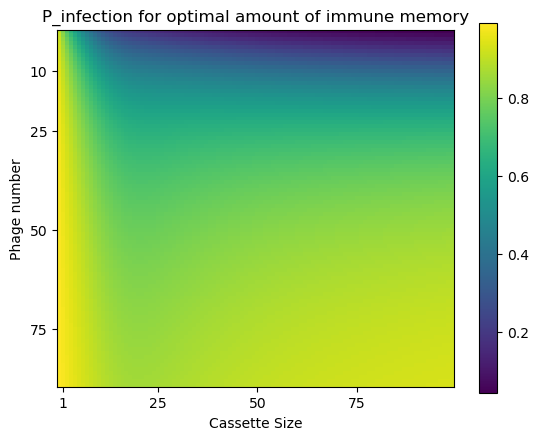

In [33]:
plt.figure()
plt.imshow(P_infection)
plt.xticks([1, 25,50, 75])
plt.yticks([10, 25, 50, 75])
plt.colorbar()
plt.title("P_infection for optimal amount of immune memory")
plt.xlabel("Cassette Size")
plt.ylabel("Phage number")

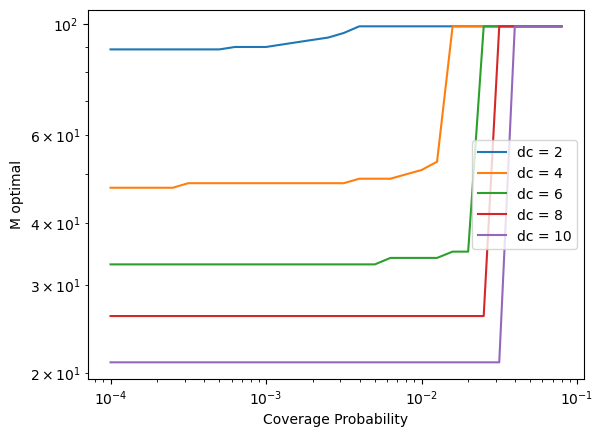

In [79]:
c_range = np.power(10, np.arange(-4, -1, 0.1))
Np = 100
M_range = np.arange(1, 100, 1)
M_min = []
plt.figure()

dc = 2
M_min = []
for c in c_range:
    P_inf_vs_M = []
    for i, M in enumerate(M_range):
        P_inf_vs_M.append(p_infection(c, M, Np, dc))

    arg_min = np.argmin(P_inf_vs_M)
    M_min.append(M_range[arg_min])

plt.plot(c_range, M_min, label = f"dc = {dc}")

dc = 4
M_min = []
for c in c_range:
    P_inf_vs_M = []
    for i, M in enumerate(M_range):
        P_inf_vs_M.append(p_infection(c, M, Np, dc))

    arg_min = np.argmin(P_inf_vs_M)
    M_min.append(M_range[arg_min])

plt.plot(c_range, M_min, label = f"dc = {dc}")

dc = 6
M_min = []
for c in c_range:
    P_inf_vs_M = []
    for i, M in enumerate(M_range):
        P_inf_vs_M.append(p_infection(c, M, Np, dc))

    arg_min = np.argmin(P_inf_vs_M)
    M_min.append(M_range[arg_min])

plt.plot(c_range, M_min, label = f"dc = {dc}")

dc = 8
M_min = []
for c in c_range:
    P_inf_vs_M = []
    for i, M in enumerate(M_range):
        P_inf_vs_M.append(p_infection(c, M, Np, dc))

    arg_min = np.argmin(P_inf_vs_M)
    M_min.append(M_range[arg_min])

plt.plot(c_range, M_min, label = f"dc = {dc}")

dc = 10
M_min = []
for c in c_range:
    P_inf_vs_M = []
    for i, M in enumerate(M_range):
        P_inf_vs_M.append(p_infection(c, M, Np, dc))

    arg_min = np.argmin(P_inf_vs_M)
    M_min.append(M_range[arg_min])

plt.plot(c_range, M_min, label = f"dc = {dc}")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Coverage Probability")
plt.ylabel("M optimal")
plt.legend()

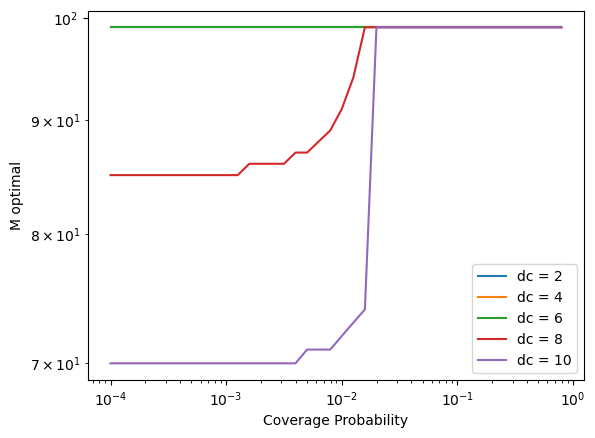

In [80]:
c_range = np.power(10, np.arange(-4, 0, 0.1))
Np = 1000
M_range = np.arange(1, 100, 1)
M_min = []
plt.figure()

dc = 2
M_min = []
for c in c_range:
    P_inf_vs_M = []
    for i, M in enumerate(M_range):
        P_inf_vs_M.append(p_infection(c, M, Np, dc))

    arg_min = np.argmin(P_inf_vs_M)
    M_min.append(M_range[arg_min])

plt.plot(c_range, M_min, label = f"dc = {dc}")

dc = 4
M_min = []
for c in c_range:
    P_inf_vs_M = []
    for i, M in enumerate(M_range):
        P_inf_vs_M.append(p_infection(c, M, Np, dc))

    arg_min = np.argmin(P_inf_vs_M)
    M_min.append(M_range[arg_min])

plt.plot(c_range, M_min, label = f"dc = {dc}")

dc = 6
M_min = []
for c in c_range:
    P_inf_vs_M = []
    for i, M in enumerate(M_range):
        P_inf_vs_M.append(p_infection(c, M, Np, dc))

    arg_min = np.argmin(P_inf_vs_M)
    M_min.append(M_range[arg_min])

plt.plot(c_range, M_min, label = f"dc = {dc}")

dc = 8
M_min = []
for c in c_range:
    P_inf_vs_M = []
    for i, M in enumerate(M_range):
        P_inf_vs_M.append(p_infection(c, M, Np, dc))

    arg_min = np.argmin(P_inf_vs_M)
    M_min.append(M_range[arg_min])

plt.plot(c_range, M_min, label = f"dc = {dc}")

dc = 10
M_min = []
for c in c_range:
    P_inf_vs_M = []
    for i, M in enumerate(M_range):
        P_inf_vs_M.append(p_infection(c, M, Np, dc))

    arg_min = np.argmin(P_inf_vs_M)
    M_min.append(M_range[arg_min])

plt.plot(c_range, M_min, label = f"dc = {dc}")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Coverage Probability")
plt.ylabel("M optimal")
plt.legend()

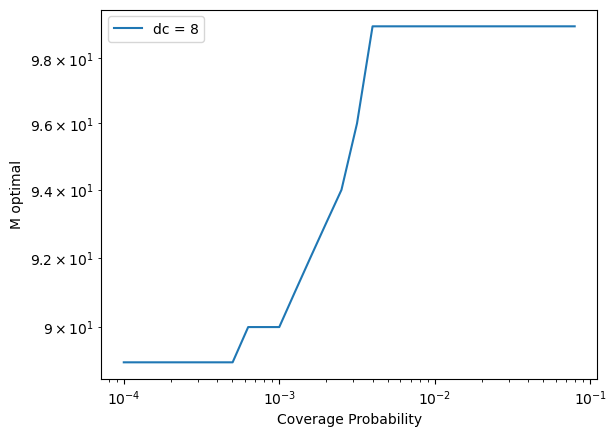

In [76]:
plt.figure()
plt.plot(c_range, M_min, label = "dc = 8")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Coverage Probability")
plt.ylabel("M optimal")
plt.legend()

In [14]:
M_range = np.arange(0, 100, 1)
p = 0.1
Np_range = np.arange(0, 100, 1)
P_infection_3D = np.zeros([len(M_range), len(Np_range)])

def p_infection(p_coverage, M, Np, dc):
    p_infection = (1-p_coverage)**M

    for n in range(1, M+1):
        p_n_spacer = binomial_pdf(M, n, p_coverage)
        for d in range(0, dc+1):
            p_infection += binomial_pdf(Np, d, n/M)*p_n_spacer
    return p_infection

for M in M_range:
    for Np in Np_range:
        P_infection_3D[M, Np] = p_infection(p, M, Np, 3)

/Users/zhizhang144515/Documents/CRISPR_Sim/Scripts/fitness.py:26: RuntimeWarning: divide by zero encountered in power
  bernouilli = np.power(p_dense, x)*np.power((1-p_dense), (n-x))
/Users/zhizhang144515/Documents/CRISPR_Sim/Scripts/fitness.py:27: RuntimeWarning: invalid value encountered in scalar multiply
  return multiplicity*bernouilli


Text(0.5, 0, 'P infection')

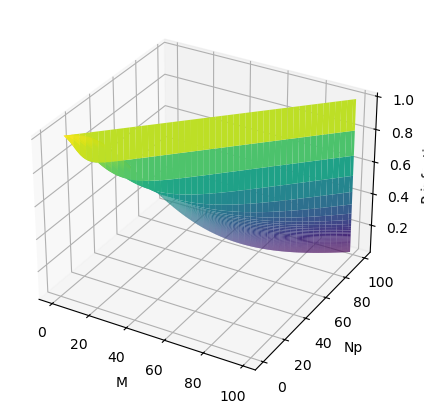

In [20]:
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111, projection = '3d')

ax.plot_surface(M_range, Np_range, P_infection_3D, cmap = 'viridis')
ax.set_xlabel('M')
ax.set_ylabel('Np')
ax.set_zlabel('P infection')

Text(0, 0.5, 'Np')

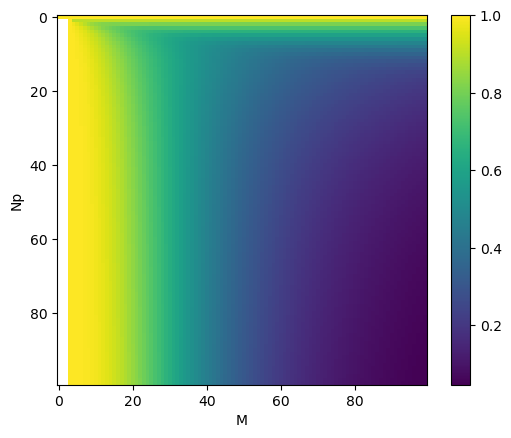

In [25]:
plt.figure()
plt.imshow(P_infection_3D)
plt.colorbar()
plt.xlabel("M")
plt.ylabel("Np")

In [29]:
def p_infection_M_derivative(p_coverage, M, Np, dc):
    if M == 0:
        return 0
    else:
        return p_infection(p_coverage, M, Np, dc) - p_infection(p_coverage, M-1, Np, dc)

Text(0, 0.5, 'P infection derivative wrt M')

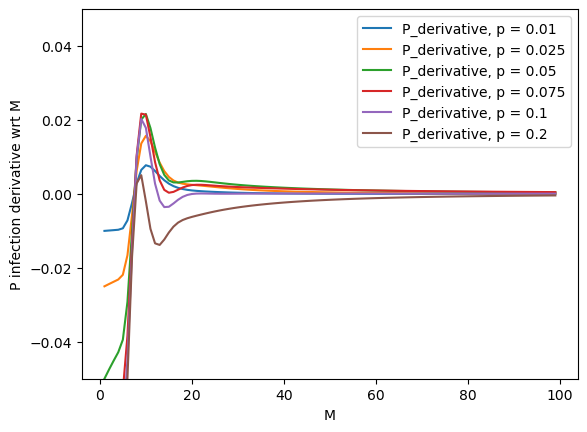

In [40]:
p_infection_range = []
p_M_derivative_infection_range = []
M_range = np.arange(1, 100, 1)



p_coverage = 0.01
p_infection_range = []
p_M_derivative_infection_range = []
for M in M_range:
    M = int(M)
    p_infection_range.append(p_infection(p_coverage, M, Np, dc))
    p_M_derivative_infection_range.append(p_infection_M_derivative(p_coverage, M, Np, dc))
# plt.plot(M_range, p_infection_range, label = "P_infection, p = 0.1", color = "red")
plt.plot(M_range, p_M_derivative_infection_range, label = f"P_derivative, p = {p_coverage}")

p_coverage = 0.025
p_infection_range = []
p_M_derivative_infection_range = []
for M in M_range:
    M = int(M)
    p_infection_range.append(p_infection(p_coverage, M, Np, dc))
    p_M_derivative_infection_range.append(p_infection_M_derivative(p_coverage, M, Np, dc))
# plt.plot(M_range, p_infection_range, label = "P_infection, p = 0.1", color = "red")
plt.plot(M_range, p_M_derivative_infection_range, label = f"P_derivative, p = {p_coverage}")

p_coverage = 0.05
p_infection_range = []
p_M_derivative_infection_range = []
for M in M_range:
    M = int(M)
    p_infection_range.append(p_infection(p_coverage, M, Np, dc))
    p_M_derivative_infection_range.append(p_infection_M_derivative(p_coverage, M, Np, dc))
# plt.plot(M_range, p_infection_range, label = "P_infection, p = 0.1", color = "red")
plt.plot(M_range, p_M_derivative_infection_range, label = f"P_derivative, p = {p_coverage}")

p_coverage = 0.075
p_infection_range = []
p_M_derivative_infection_range = []
for M in M_range:
    M = int(M)
    p_infection_range.append(p_infection(p_coverage, M, Np, dc))
    p_M_derivative_infection_range.append(p_infection_M_derivative(p_coverage, M, Np, dc))
# plt.plot(M_range, p_infection_range, label = "P_infection, p = 0.1", color = "red")
plt.plot(M_range, p_M_derivative_infection_range, label = f"P_derivative, p = {p_coverage}")

p_coverage = 0.1
p_infection_range = []
p_M_derivative_infection_range = []
for M in M_range:
    M = int(M)
    p_infection_range.append(p_infection(p_coverage, M, Np, dc))
    p_M_derivative_infection_range.append(p_infection_M_derivative(p_coverage, M, Np, dc))
# plt.plot(M_range, p_infection_range, label = "P_infection, p = 0.1", color = "red")
plt.plot(M_range, p_M_derivative_infection_range, label = f"P_derivative, p = {p_coverage}")

p_coverage = 0.2
p_infection_range = []
p_M_derivative_infection_range = []
for M in M_range:
    M = int(M)
    p_infection_range.append(p_infection(p_coverage, M, Np, dc))
    p_M_derivative_infection_range.append(p_infection_M_derivative(p_coverage, M, Np, dc))
# plt.plot(M_range, p_infection_range, label = "P_infection, p = 0.1", color = "red")
plt.plot(M_range, p_M_derivative_infection_range, label = f"P_derivative, p = {p_coverage}")

# p_coverage = 0.9
# p_infection_range = []
# p_M_derivative_infection_range = []
# for M in M_range:
#     M = int(M)
#     p_infection_range.append(p_infection(p_coverage, M, Np, dc))
#     p_M_derivative_infection_range.append(p_infection_M_derivative(p_coverage, M, Np, dc))
# # plt.plot(M_range, p_infection_range, label = "P_infection, p = 0.1", color = "red")
# plt.plot(M_range, p_M_derivative_infection_range, label = f"P_derivative, p = {p_coverage}")

plt.legend()
plt.xlabel("M")
plt.ylim(-0.05, 0.05)
plt.ylabel("P infection derivative wrt M")

(0.0, 100.0)

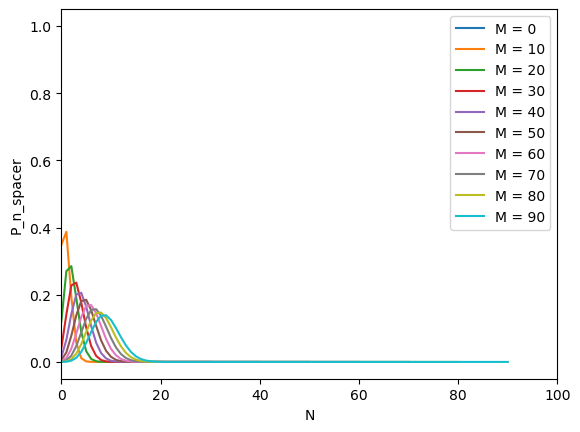

In [55]:
M_range = np.arange(0, 100, 1)
p_coverage = 0.1

for M in M_range:
    p_n_spacer = []
    
    if M%10 == 0:
        for n in range(M+1):
            p_n_spacer.append(binomial_pdf(M, n, p_coverage))
        plt.plot(p_n_spacer, label = f"M = {M}")

# plt.xscale("log")
plt.xlabel("N")
plt.ylabel("P_n_spacer")
plt.legend()
plt.xlim(0,100)

(0.0, 100.0)

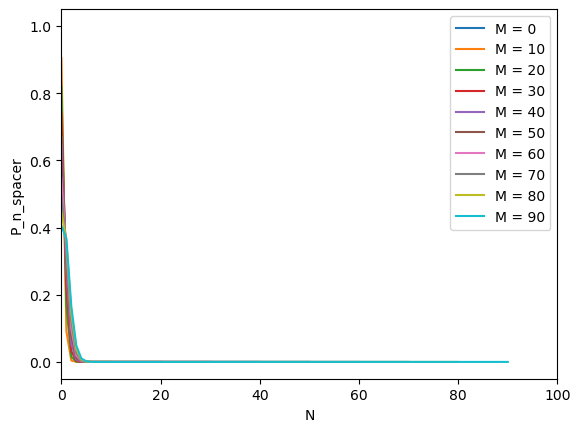

In [56]:
M_range = np.arange(0, 100, 1)
p_coverage = 0.01

for M in M_range:
    p_n_spacer = []
    
    if M%10 == 0:
        for n in range(M+1):
            p_n_spacer.append(binomial_pdf(M, n, p_coverage))
        plt.plot(p_n_spacer, label = f"M = {M}")

# plt.xscale("log")
plt.xlabel("N")
plt.ylabel("P_n_spacer")
plt.legend()
plt.xlim(0,100)

(0.0, 100.0)

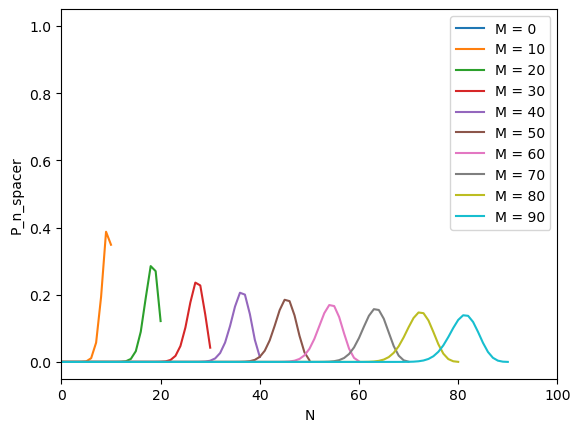

In [54]:
M_range = np.arange(0, 100, 1)
p_coverage = 0.9

for M in M_range:
    p_n_spacer = []
    
    if M%10 == 0:
        for n in range(M+1):
            p_n_spacer.append(binomial_pdf(M, n, p_coverage))
        plt.plot(p_n_spacer, label = f"M = {M}")

# plt.xscale("log")
plt.xlabel("N")
plt.ylabel("P_n_spacer")
plt.legend()
plt.xlim(0,100)

/var/folders/9_/htwk2tpd6tv_fy1sp81nfcsm0000gn/T/ipykernel_31594/4017696823.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  p_1_spacer.append(binomial_pdf(Np, d, 1/M))


(0.0, 10.0)

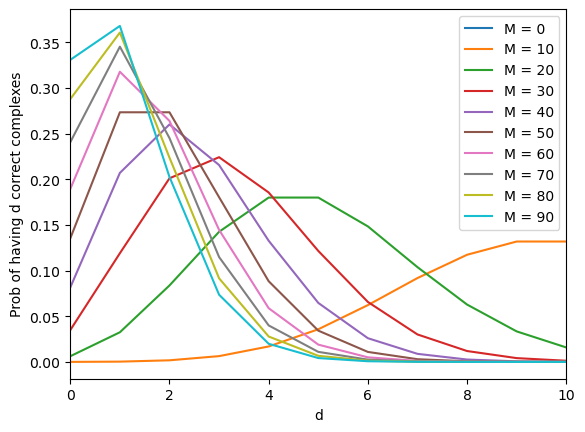

In [60]:
M_range = np.arange(0, 100, 1)
p_coverage = 0.1

for M in M_range:
    p_1_spacer = []
    
    if M%10 == 0:
        for d in range(101):
            p_1_spacer.append(binomial_pdf(Np, d, 1/M))
        plt.plot(p_1_spacer, label = f"M = {M}")

# plt.xscale("log")
plt.xlabel("d")
plt.ylabel("Prob of having d correct complexes")
plt.legend()
plt.xlim(0,10)

/var/folders/9_/htwk2tpd6tv_fy1sp81nfcsm0000gn/T/ipykernel_31594/4287341692.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  p_1_spacer.append(binomial_pdf(Np, d, 1/M))
/var/folders/9_/htwk2tpd6tv_fy1sp81nfcsm0000gn/T/ipykernel_31594/4287341692.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  p_1_spacer_normal.append(normal_pdf(d, Np/M, (Np/M)))
/var/folders/9_/htwk2tpd6tv_fy1sp81nfcsm0000gn/T/ipykernel_31594/4287341692.py:3: RuntimeWarning: invalid value encountered in scalar divide
  B = np.exp(-0.5*np.power(x-mean, 2)/variance)


(0.0, 10.0)

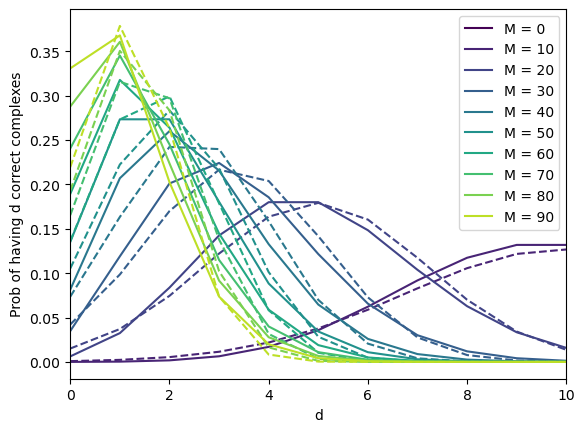

In [63]:
def normal_pdf(x, mean, variance):
    A = 1/(np.sqrt(variance*2*np.pi))
    B = np.exp(-0.5*np.power(x-mean, 2)/variance)
    return A*B

M_max = 100
M_range = np.arange(0, M_max, 1)
p_coverage = 0.1

cmap = plt.get_cmap('viridis')
colors = [cmap(i / n) for i in range(n)]


for M in M_range:
    p_1_spacer = []
    p_1_spacer_normal = []
    
    if M%10 == 0:
        for d in range(101):
            p_1_spacer.append(binomial_pdf(Np, d, 1/M))
            p_1_spacer_normal.append(normal_pdf(d, Np/M, (Np/M)))
        plt.plot(p_1_spacer, label = f"M = {M}", color = cmap(M/M_max))
        plt.plot(p_1_spacer_normal, linestyle = "--", color = cmap(M/M_max))

# plt.xscale("log")
plt.xlabel("d")
plt.ylabel("Prob of having d correct complexes")
plt.legend()
plt.xlim(0,10)

Text(0.5, 1.0, 'Probability of Infection at p = 0.2 & 0.01 , dc = 3')

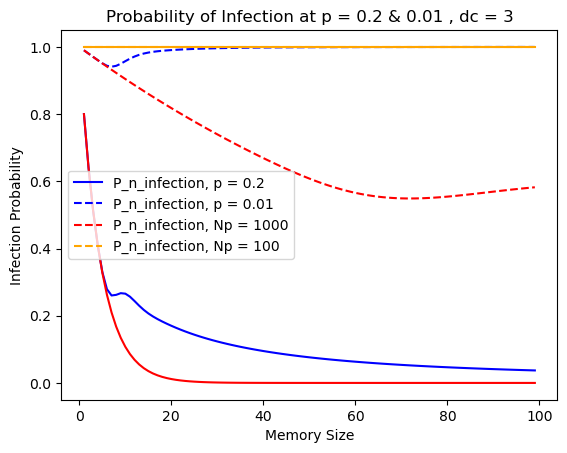

In [8]:
M_range = np.arange(1, 100)
dc = 10

Np = 100
p_coverage = 0.2
p_infection_range = []
p_1_infection_range = []
for M in M_range:
    p_infection_range.append(p_infection(p_coverage, M, Np, dc))
plt.plot(M_range, p_infection_range, label = "P_n_infection, p = 0.2", color = "blue")

p_coverage = 0.01
p_infection_range = []
p_1_infection_range = []
for M in M_range:
    p_infection_range.append(p_infection(p_coverage, M, Np, dc))
plt.plot(M_range, p_infection_range, label = "P_n_infection, p = 0.01", color = "blue", linestyle = "--")

Np = 1000
p_coverage = 0.2
p_infection_range = []
p_1_infection_range = []
for M in M_range:
    p_infection_range.append(p_infection(p_coverage, M, Np, dc))
plt.plot(M_range, p_infection_range, color = "red")

p_coverage = 0.01
p_infection_range = []
p_1_infection_range = []
for M in M_range:
    p_infection_range.append(p_infection(p_coverage, M, Np, dc))
plt.plot(M_range, p_infection_range, label = "P_n_infection, Np = 1000", color = "red", linestyle = "--")

Np = 10
p_coverage = 0.2
p_infection_range = []
p_1_infection_range = []
for M in M_range:
    p_infection_range.append(p_infection(p_coverage, M, Np, dc))
plt.plot(M_range, p_infection_range, color = "orange")

p_coverage = 0.01
p_infection_range = []
p_1_infection_range = []
for M in M_range:
    p_infection_range.append(p_infection(p_coverage, M, Np, dc))
plt.plot(M_range, p_infection_range, label = "P_n_infection, Np = 100", color = "orange", linestyle = "--")


plt.legend()
plt.xlabel("Memory Size")
plt.ylabel("Infection Probability")
plt.title("Probability of Infection at p = 0.2 & 0.01 , dc = 3")

Text(0.5, 1.0, 'Check for Correctness')

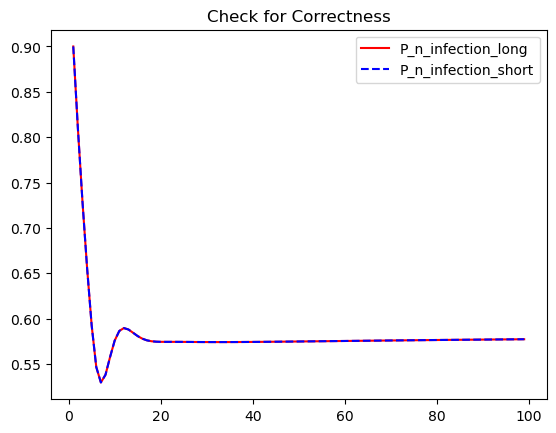

In [176]:
def p_infection_short(p_coverage, M, Np, dc):
    p_infection = 0
    for n in range(0, M+1):
        p_n_spacer = binomial_pdf(M, n, p_coverage)
        for d in range(0, dc+1):
            p_infection += binomial_pdf(Np, d, n/M)*p_n_spacer
    return p_infection

M_range = np.arange(1, 100)
dc = 10

Np = 100
p_coverage = 0.1
p_infection_range = []
p_1_infection_range = []
for M in M_range:
    p_infection_range.append(p_infection(p_coverage, M, Np, dc))
plt.plot(M_range, p_infection_range, label = "P_n_infection_long", color = "Red")

p_coverage = 0.1
p_infection_range = []
p_1_infection_range = []
for M in M_range:
    p_infection_range.append(p_infection_short(p_coverage, M, Np, dc))
plt.plot(M_range, p_infection_range, label = "P_n_infection_short", color = "blue", linestyle = "--")
plt.legend()
plt.title("Check for Correctness")

In [191]:
params = { #parameters relevant for the equations
    "Nh":             1e9,
    "N0":           10000,
    "R0":              20,
    "M":               20, #Also L, total number of spacers
    "mu":             100, #mutation rate
    "gamma_shape":     20, 
    "Np":             100, #Number of Cas Protein
    "dc":              10, #Required number of complexes to activate defence
    "h":              100, #coordination coeff
    "r":             500, #cross-reactivity kernel
    "rate_HGT":         0,
}
sim_params = { #parameters relevant for the simulation (including Inital Valuess)
    "xdomain":                   1000,
    "dx":                           1,
    "tf":                        1000,
    "dt":                           1,
    "initial_mean_n":           [0,0],
    "initial_mean_nh":          [0,0],
    "conv_size":                 4000,
    "num_threads":                 32,
    "tail_axis":               [1, 1],
    "hard_N0":                  False,
}

In [154]:
params, simparams = init_cond(params, sim_params, False)

In [192]:
def coverage_range(params, sim_params, return_type = "full"):
    r = params["r"]
    v = params["v0"]
    tau = params["tau"]
    distance = np.sqrt(params["sigma"])

    def front_coverage(u_range, r, v, tau):
        A = r/(r+v*tau)
        front_coverage_range = A*np.exp(-u_range/r)
        return front_coverage_range
    
    def back_coverage(u_range, r, v, tau):
        A = r/(r-v*tau)
        back_coverage_range = A*(np.exp(-u_range/r) - np.exp(-u_range/(v*tau)))
        return back_coverage_range
    
    u_range = np.arange(0, distance, 1)
    front_range = front_coverage(u_range, r, v, tau)
    back_range = back_coverage(u_range, r, v, tau)
    full_range = np.concatenate([back_range, front_range], axis = 0)

    if return_type == "full":
        u_range_flip = np.flip(-1*u_range)
        full_u_range= np.concatenate([u_range_flip, u_range], axis = 0)
        return full_u_range, full_range
    
    if return_type == "front":
        return u_range, front_range
    
    if return_type == "back":
        return u_range, back_range
    


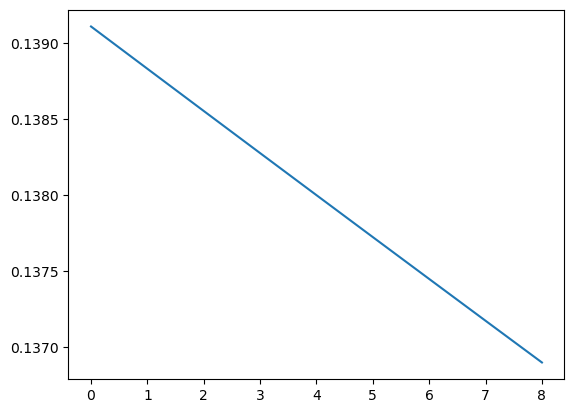

In [156]:
u_range, full_range = coverage_range(params, sim_params, "front")
plt.plot(u_range, full_range)

In [337]:
def fitness_n_spacers(p_coverage, params, sim_params):
    M = params["M"]
    R0 = params["R0"]
    Np = params["Np"]
    dc = params["dc"]

    def p_infection(p_coverage, M, Np, dc):
        p_infection = (1-p_coverage)**M

        for n in range(1, M+1):
            p_n_spacer = binomial_pdf(M, n, p_coverage)
            for d in range(0, dc+1):
                p_infection += binomial_pdf(Np, d, n/M)*p_n_spacer
        return p_infection
    
    p_inf = p_infection(p_coverage, M, Np, dc)
    return np.log(R0*p_inf)

def p_infection(p_coverage, params, sim_params):
    M = params["M"]
    Np = params["Np"]
    dc = params["dc"]
    
    p_infection = 0
    for n in range(0, M+1):
        p_n_spacer = binomial_pdf(M, n, p_coverage)
        for d in range(0, dc+1):
            p_infection += binomial_pdf(Np, d, n/M)*p_n_spacer
    return p_infection

def derivative_p_infection(p_coverage, params, sim_params):
    M = params["M"]
    R0 = params["R0"]
    Np = params["Np"]
    dc = params["dc"]

    derivative_p_infection = 0
    for n in range(0, M+1):
        derivative_p_n_spacer = n*(binomial_pdf(M, n, p_coverage)/p_coverage)
        derivative_p_n_spacer -= (M-n)*(binomial_pdf(M, n, p_coverage)/(1-p_coverage))

        for d in range(0, dc+1):
            derivative_p_infection += binomial_pdf(Np, d, n/M)*derivative_p_n_spacer
    return derivative_p_infection

In [341]:
params["Np"] = 100
p_coverage = 0.01
params["dc"] = 10

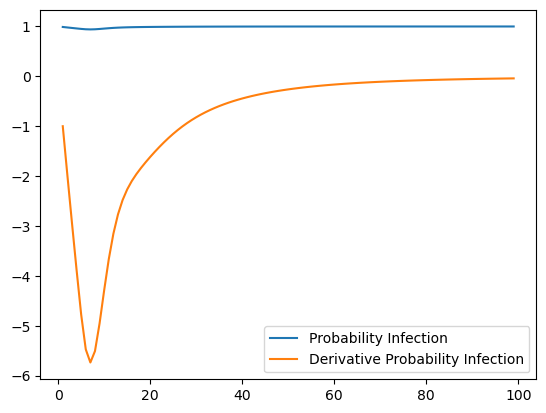

In [344]:
M_range = np.arange(1, 100)
p_inf_range = []
der_p_inf_range = []

for M in M_range:
    params["M"] = M
    p_inf_range.append(p_infection(p_coverage, params, sim_params))
    der_p_inf_range.append(derivative_p_infection(p_coverage, params, sim_params))

plt.plot(M_range, p_inf_range, label = "Probability Infection")
plt.plot(M_range, der_p_inf_range, label = "Derivative Probability Infection")
plt.legend()

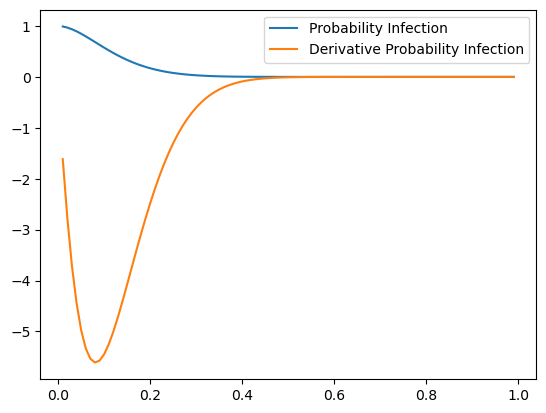

In [203]:
p_range = np.arange(0.01, 1, 0.01)
p_inf_range = []
der_p_inf_range = []

for p in p_range:
    p_inf_range.append(p_infection(p, params, sim_params))
    der_p_inf_range.append(derivative_p_infection(p, params, sim_params))

plt.plot(p_range, p_inf_range, label = "Probability Infection")
plt.plot(p_range, der_p_inf_range, label = "Derivative Probability Infection")
plt.legend()
# plt.yscale("log")

In [214]:
def fitness(p_coverage, params, sim_params):
    M = params["M"]
    R0 = params["R0"]
    Np = params["Np"]
    dc = params["dc"]

    p_inf = p_infection(p_coverage, params, sim_params)
    fit = np.log(R0*p_inf)
    return fit


def derivative_fitness(p_coverage, params, sim_params):
    M = params["M"]
    R0 = params["R0"]
    Np = params["Np"]
    dc = params["dc"]

    p_inf = p_infection(p_coverage, params, sim_params)
    derivative_p_inf = derivative_p_infection(p_coverage, params, sim_params)
    derivative_fit = (1/p_inf)*derivative_p_inf
    return derivative_fit

Text(0.5, 1.0, 'Fitness vs Probability Coverage')

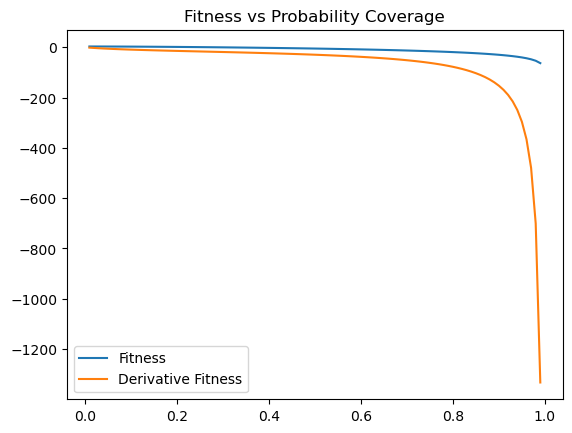

In [222]:
p_range = np.arange(0.01, 1, 0.01)
fit_range = []
der_fit_range = []

for p in p_range:
    fit_range.append(fitness(p, params, sim_params))
    der_fit_range.append(derivative_fitness(p, params, sim_params))

plt.plot(p_range, fit_range, label = "Fitness")
plt.plot(p_range, der_fit_range, label = "Derivative Fitness")
plt.legend()
# plt.yscale("log")
plt.title("Fitness vs Probability Coverage")

In [258]:
import numpy as np
from scipy.optimize import fsolve

def find_root_fitness(params, sim_params, n_itr = 1000, err = 1e-7, to_print = False):
    x_old = 0.5

    for i in range(n_itr):
        f0 = fitness_n_spacers(x_old, params, sim_params)
        if to_print:
            print("New Root: ", x_old,"|  New Fitness:  ", f0)
        f_prime = derivative_fitness(x_old, params, sim_params)
        
        x_new = x_old - (f0/f_prime)
        if np.abs(x_new - x_old) < err:
            break
        x_old = x_new

    return x_new

# Find the zeros of the function
roots = find_root_fitness(params, sim_params)

Text(0.5, 1.0, 'Fitness vs Probability Coverage')

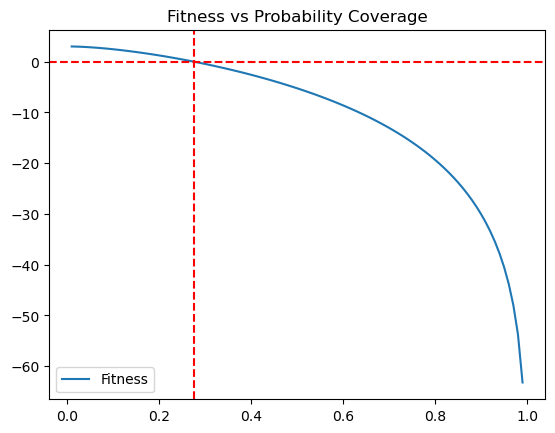

In [230]:
plt.plot(p_range, fit_range, label = "Fitness")
plt.axvline(roots, color = "red", linestyle='--')
plt.axhline(0, color = "red", linestyle='--')
plt.legend()
# plt.yscale("log")
plt.title("Fitness vs Probability Coverage")

In [253]:
def return_v_tau(params, sim_params):
    r = params["r"]
    root_c = find_root_fitness(params, sim_params)
    A = root_c/(1-root_c)
    return r/A

def return_s(params, sim_params):
    r = params["r"]

    c_0 = find_root_fitness(params, sim_params)
    derivative_c_0 = c_0*(-1/r)
    der_fit = derivative_fitness(c_0, params, sim_params)
    return derivative_c_0*der_fit

In [259]:
def fill_parameters2(params, sim_params):
    R0 = params["R0"]
    M = params["M"]
    N = params["N"]
    Nh = params["Nh"]
    r = params["r"]
    v0 = 0
    sigma = 0

    params["D"] = D = calc_diff_const(params, sim_params)
    params["s"] = s = return_s(params, sim_params)
    params["tau"] = tau = M*Nh/N

    common_log = 24*np.log(N*np.power(D*np.power(s,2), 1/3))
    # print(f"D: {D}| s:{s}| common_log: {common_log}")
    if common_log < 0:
        raise(ValueError("INCREASE Nh YOUR EXPECTED POPULATION IS 0"))
    sigma = np.power(D/s, 1/3)*np.power(common_log, 1/6)
    v0 = np.power(s, 1/3)*np.power(D, 2/3)*np.power(common_log, 1/3)
    uc = s*np.power(sigma, 4)/(4*D)

    params["v_tau"] = return_v_tau(params, sim_params)
    params["v0"] = v0
    params["sigma"] = sigma
    params["uc"] = uc
    params["M0"] = M
    return params, sim_params

def init_cond2(params, sim_params, out_print = False):
    Nh = params["Nh"]
    N0 = params["N0"]
    params["N"] = N0
    i = 0

    if sim_params["hard_N0"]:
        params, sim_params = fill_parameters2(params, sim_params)
        i = 101

    while(i < 100):
        params, sim_params = fill_parameters2(params, sim_params)
        N0 = params["N"]
        uc = params["uc"]
        sigma = params["sigma"]
        if out_print:
            print(f"Phage Population: {N0:.4f}| Uc: {uc:.4f}| sigma: {sigma:.4f}")
        
        if np.isnan(uc) or np.isnan(sigma):
            raise(ValueError("You need >10E6 Nh or >10E3 N0"))
        
        N = Nh*params["v0"]*params["M"]/params["v_tau"]
        params["N"] = N
        i   += 1
        if np.abs(N0-N) <= 0.5:
            params["N"] = int(N)
            params, sim_params = fill_parameters2(params, sim_params)
            uc = params["uc"]
            sigma = params["sigma"]
            if out_print:
                print(f"Phage Population: {N:.4f}| Uc: {uc:.4f}| sigma: {sigma:.4f}")
            break

    uc = params["uc"]
    sigma = params["sigma"]
    params["N0"] = params["N"] #update actual N
    sim_params["initial_var_n"] = sigma
    sim_params["initial_var_nh"] = np.sqrt(np.power(sigma, 2) + np.power(uc, 2))
    sim_params["time_next_event"] = get_time_next_HGT(0, params, sim_params)
    return params, sim_params

In [325]:
params_init = { #parameters relevant for the equations
    "Nh":             1e7,
    "N0":           10000,
    "R0":              20,
    "M":               20, #Also L, total number of spacers
    "mu":             100, #mutation rate
    "gamma_shape":     20, 
    "Np":             100, #Number of Cas Protein
    "dc":              10, #Required number of complexes to activate defence
    "h":              100, #coordination coeff
    "r":             2000, #cross-reactivity kernel
    "rate_HGT":         0,
}
sim_params_init = { #parameters relevant for the simulation (including Inital Valuess)
    "xdomain":                   1000,
    "dx":                           1,
    "tf":                        1000,
    "dt":                           1,
    "initial_mean_n":           [0,0],
    "initial_mean_nh":          [0,0],
    "conv_size":                 4000,
    "num_threads":                 32,
    "tail_axis":               [1, 1],
    "hard_N0":                  False,
}

In [326]:
params, sim_params = init_cond2(params_init, sim_params_init, True)

Phage Population: 10000.0000| Uc: 259.6723| sigma: 81.5595
Phage Population: 622769.1127| Uc: 356.9081| sigma: 88.3094
Phage Population: 730116.9208| Uc: 360.3745| sigma: 88.5231
Phage Population: 733653.9419| Uc: 360.4796| sigma: 88.5295
Phage Population: 733760.8962| Uc: 360.4828| sigma: 88.5297
Phage Population: 733764.1219| Uc: 360.4829| sigma: 88.5297
Phage Population: 733764.2191| Uc: 360.4828| sigma: 88.5297


In [327]:
mu_range = np.power(10, np.arange(-2, 3, 0.1))

N_range = []
v_range = []
for mu in mu_range:
    params_init["mu"] = mu
    params, sim_params = init_cond2(params_init, sim_params_init)
    v_range.append(params["v0"])
    N_range.append(params["N0"])

Text(0.5, 0, 'mutation rate')

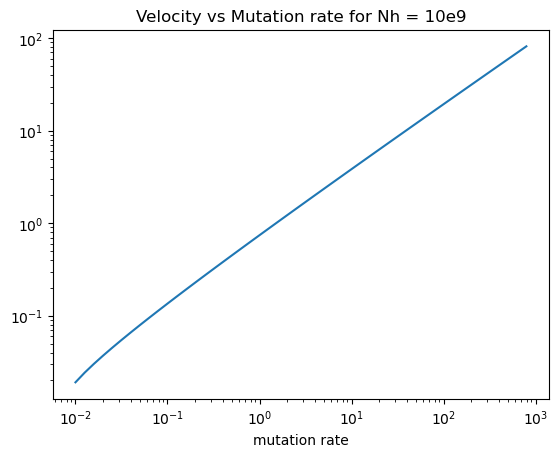

In [328]:
plt.plot(mu_range, v_range)
plt.yscale("log")
plt.xscale("log")
plt.title("Velocity vs Mutation rate for Nh = 10e9")
plt.xlabel("mutation rate")

Text(0.5, 0, 'mutation rate')

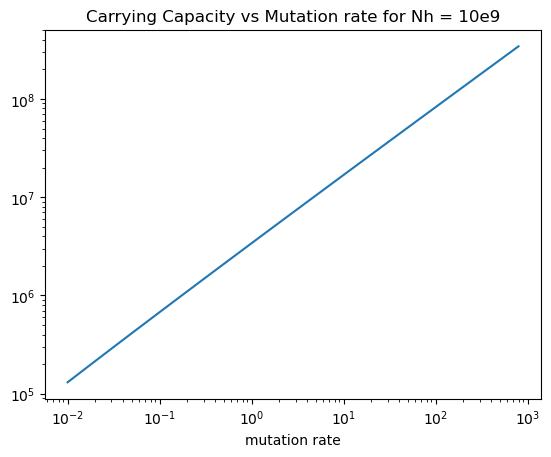

In [280]:
plt.plot(mu_range, N_range)
plt.yscale("log")
plt.xscale("log")
plt.title("Carrying Capacity vs Mutation rate for Nh = 10e9")
plt.xlabel("mutation rate")

In [294]:
r_range = np.power(10, np.arange(2, 4, 0.1))

N_range = []
sigma_range = []

for r in r_range:
    params_init["r"] = r
    params, sim_params = init_cond2(params_init, sim_params_init)
    N_range.append(params["N0"])
    sigma_range.append(params["sigma"])

Text(0.5, 0, 'Cross-Reactivity Range')

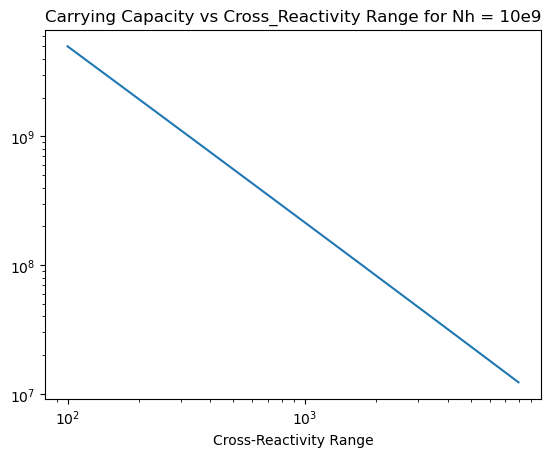

In [285]:
plt.plot(r_range, N_range)
plt.yscale("log")
plt.xscale("log")
plt.title("Carrying Capacity vs Cross_Reactivity Range for Nh = 10e9")
plt.xlabel("Cross-Reactivity Range")

Text(0.5, 0, 'Cross-Reactivity Range')

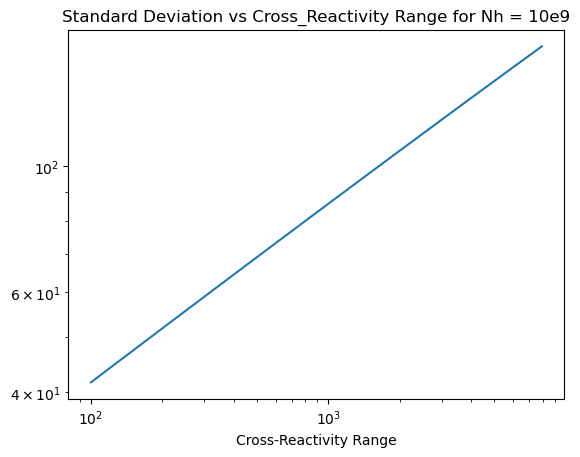

In [295]:
plt.plot(r_range, sigma_range)
plt.yscale("log")
plt.xscale("log")
plt.title("Standard Deviation vs Cross_Reactivity Range for Nh = 10e9")
plt.xlabel("Cross-Reactivity Range")

In [290]:
Np_range = np.power(10, np.arange(1.5, 4, 0.1))

N_range = []
for Np in Np_range:
    params_init["Np"] = Np
    params, sim_params = init_cond2(params_init, sim_params_init)
    N_range.append(params["N0"])
    sigma_range.append(params["sigma"])

Text(0.5, 0, 'Np range')

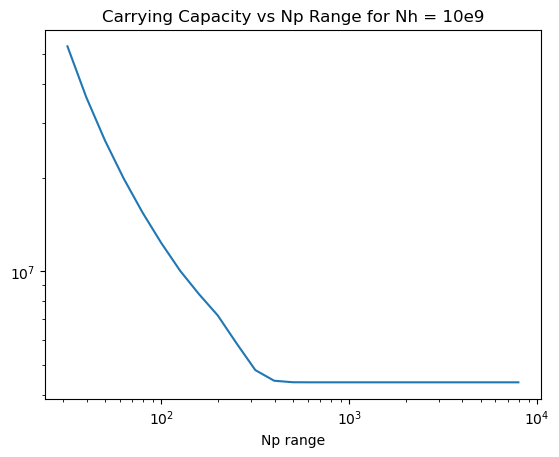

In [292]:
plt.plot(Np_range, N_range)
plt.yscale("log")
plt.xscale("log")
plt.title("Carrying Capacity vs Np Range for Nh = 10e9")
plt.xlabel("Np range")